In [2]:
import pickle
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement, qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.generation.sampling import MaxPosteriorSampling

from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator, DistanceEstimator, MAFMOGDensityEstimator, MADEMOGDensityEstimator,
                                       create_network, create_optimizer, create_multiplicative_scheduler, VarianceSource)
from uncertaintylearning.models import EpistemicPredictor, MCDropout
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neighbors import KernelDensity

from torch.utils.data import DataLoader, TensorDataset
from torch.quasirandom import SobolEngine

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from uncertaintylearning.utils import functions, bounds as boundsx
from uncertaintylearning.utils.feature_generator import FeatureGenerator
from uncertaintylearning.utils.density_estimator import FixedSmoothKernelDensityEstimator
from uncertaintylearning.utils.density_picker import CrossValidator
from uncertaintylearning.utils.buffer import Buffer
from uncertaintylearning.utils.smo import init_buffer, optimize, make_feature_generator, one_step_acquisition

from copy import deepcopy
from itertools import product
functions

{'sinusoid': <function uncertaintylearning.utils.test_functions.sinusoid(X, noise)>,
 'multi_optima': <function uncertaintylearning.utils.test_functions.multi_optima(X, noise)>,
 'booth': <function uncertaintylearning.utils.test_functions.booth(X, noise)>,
 'levi_n13': <function uncertaintylearning.utils.test_functions.levi_n13(X, noise)>,
 'ackley200': <function uncertaintylearning.utils.test_functions.ackley200(X, noise)>,
 'ackley10': <function uncertaintylearning.utils.test_functions.ackley10(X, noise)>}

## multi_optima_fct

In [157]:
fct_name = 'multi_optima'
fct = functions[fct_name]
dim, bounds = boundsx[fct_name]
noise = 0
f = lambda x: fct(x, 0)
x = torch.linspace(-1, 2, 1000).unsqueeze(-1)

In [158]:
results = pickle.load(open('pickles/multi_optima.pkl', 'rb'))
n_steps = 50

In [159]:
x_random = torch.zeros((56, 500)).uniform_(-1, 2)
y_random = f(x_random)
random_acq = np.maximum.accumulate(y_random, axis=0).numpy().T[:, -51:]
random_acq.shape


(500, 51)

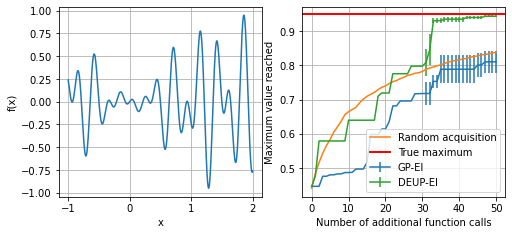

In [160]:

fig, axes = plt.subplots(1, 2, figsize = (8, 3.5))
axes[0].plot(x, f(x).squeeze())
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')
axes[0].grid()
axes[1].errorbar(range(1 + n_steps), results['gp'].mean(0), results['gp'].std(0) * (np.arange(51) > 30) / np.sqrt(5), label='GP-EI')
axes[1].plot(range(1 + n_steps), random_acq.mean(0), label='Random acquisition')

axes[1].errorbar(range(1 + n_steps), results['gpdeup'].mean(0), results['gpdeup'].std(0) * (np.arange(51) > 30) / np.sqrt(5), label='DEUP-EI')
axes[1].axhline(f(x).max(), linewidth=2, color='r', label='True maximum')
axes[1].legend()
axes[1].set_xlabel("Number of additional function calls")
axes[1].set_ylabel("Maximum value reached")
axes[1].grid()
plt.savefig('figs/multioptima_results_new.pdf')

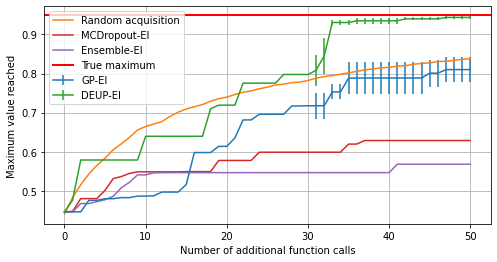

In [162]:
# APPENDIX PLOT with all methods
plt.figure(figsize = (8, 4))
plt.errorbar(range(1 + n_steps), results['gp'].mean(0), results['gp'].std(0) * (np.arange(51) > 30) / np.sqrt(5), label='GP-EI')
plt.plot(range(1 + n_steps), random_acq.mean(0), label='Random acquisition')
plt.errorbar(range(1 + n_steps), results['gpdeup'].mean(0), results['gpdeup'].std(0) * (np.arange(51) > 30) / np.sqrt(5), label='DEUP-EI')
plt.plot(range(1 + n_steps), results['mcdropout'].mean(0), label='MCDropout-EI')
plt.plot(range(1 + n_steps), results['ensemble'].mean(0), label='Ensemble-EI')
plt.axhline(f(x).max().item(), linewidth=2, color='r', label='True maximum')
plt.legend()
plt.grid()
plt.xlabel("Number of additional function calls")
plt.ylabel("Maximum value reached")
plt.savefig('figs/multioptima_results_appendix.pdf')
plt.show()

## LEVI N 13 FUNCTION

In [164]:
fct_name = 'levi_n13'
fct = functions[fct_name]
dim, bounds = boundsx[fct_name]
noise = 0
f = lambda x: fct(x, 0)
results = pickle.load(open('pickles/levi_n13_large.pkl', 'rb'))
n_steps = 50

In [171]:
x_random = torch.zeros((56, 50, 2)).uniform_(-10, 10)
y_random = f(x_random.view(-1, x_random.size(-1))).view(x_random.size(0), x_random.size(1))
random_acq = np.maximum.accumulate(y_random, axis=0).numpy().T[:, -51:]
random_acq.shape


(50, 51)

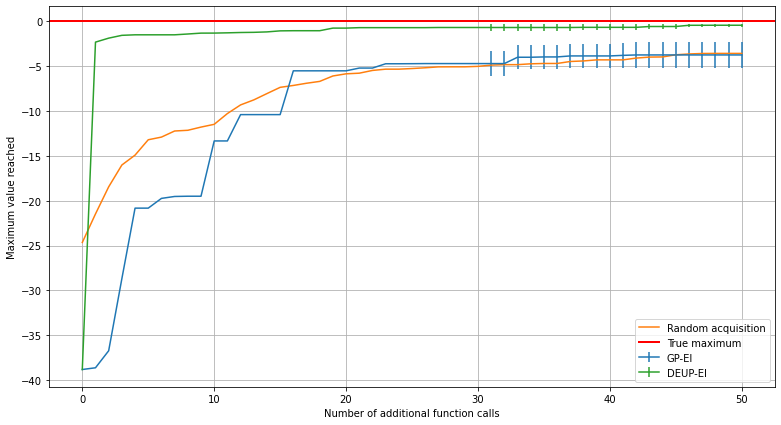

In [172]:
plt.figure(figsize = (13, 7))
plt.errorbar(range(1 + n_steps), results['gp'].mean(0), results['gp'].std(0) * (np.arange(51) > 30) / np.sqrt(5), label='GP-EI')
plt.plot(range(1 + n_steps), random_acq.mean(0), label='Random acquisition')
plt.errorbar(range(1 + n_steps), results['gpdeup'].mean(0), results['gpdeup'].std(0) * (np.arange(51) > 30) / np.sqrt(5), label='DEUP-EI')
plt.axhline(0, linewidth=2, color='r', label='True maximum')
plt.legend()
plt.grid()
plt.xlabel("Number of additional function calls")
plt.ylabel("Maximum value reached")
plt.savefig('figs/levi_n13_results_appendix.pdf')
plt.show()

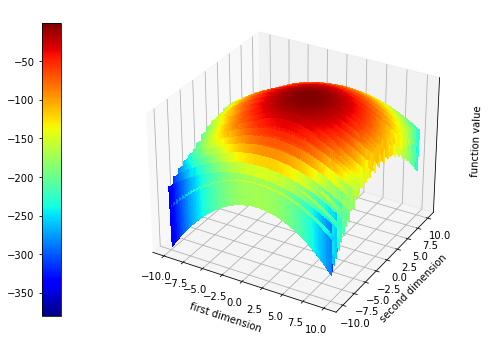

In [191]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
def func(x,y, noise):
    return noise * torch.randn(x.size(0)) - (torch.sin(3 * np.pi * x) ** 2 +
                                                (x - 1) ** 2 * (1 + torch.sin(3 * np.pi * y) ** 2) +
                                                (y - 1) ** 2 * (1 + torch.sin(2 * np.pi * y) ** 2))

bounds = (-10, 10)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
# plot a 3D surface like in the example mplot3d/surface3d_demo
#ax = fig.gca(projection='3d')
X = torch.linspace(*bounds, 100)
Y = torch.linspace(*bounds, 100)
X, Y = torch.meshgrid(X, Y)
Z = func(X, Y, 0)
X = X.numpy()
Y = Y.numpy()
Z = Z.numpy()
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('first dimension')
ax.set_ylabel('second dimension')
ax.set_zlabel('function value')
fig.colorbar(surf, aspect=15, ax=[ax], location='left', shrink=0.9)
ax.set_zticks([])
plt.savefig('figs/levi3d.pdf')
plt.show()

In [151]:
ax

<Axes3DSubplot:>

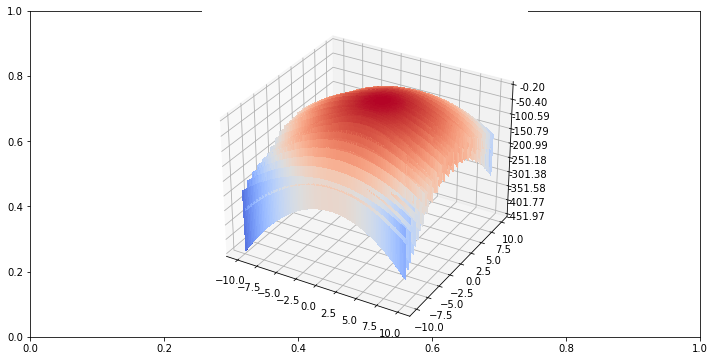

In [183]:
bounds = (-10, 10)
fig, ax = plt.subplots(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
# plot a 3D surface like in the example mplot3d/surface3d_demo
#ax = fig.gca(projection='3d')
X = torch.linspace(*bounds, 100)
Y = torch.linspace(*bounds, 100)
X, Y = torch.meshgrid(X, Y)
Z = func(X, Y, 0)
X = X.numpy()
Y = Y.numpy()
Z = Z.numpy()
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# fig.colorbar(surf, aspect=15, ax=[ax], location='left',shrink=0.5)
plt.savefig('figs/levi3d.pdf')
plt.show()